In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, ConnectionPatch
from matplotlib.ticker import FuncFormatter
from operator import methodcaller
from PIL import Image

def load_image(filename) :
    img = Image.open(filename)
    img.load()
    data = np.asarray(img, dtype="int32")
    data = np.flipud(data)
    return data

get_distance = lambda p1, p2: math.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)
get_midpoint = lambda p1, p2: (0.5 * (p1[0] + p2[0]), 0.5 * (p1[1] + p2[1]))

def convert_point(p: tuple, rate: float):
    return (rate * p[0], rate * p[1])

STD_G = 9.81

Preprocess csv data from excel-like sheet.

In [2]:
df = pd.read_csv('measures.csv', dtype='str')
img = load_image('photo.jpg')

df = df.apply(lambda x: x.str.replace(',','.'))
df.length = df.length.astype('float')
df.mass = df.mass.astype('float')
df.dtypes

segment     object
length     float64
mass       float64
dtype: object

Anchor points usde to calculate midpoints.

In [3]:
r_feet_end = (100, 800)
r_feet_ankle = (300, 820)
r_knee = (730, 1160)
r_hip_joint = (1230, 1430)

l_feet_end = (1600, 50)
l_feet_ankle = (1600, 250)
l_knee = (1550, 700)
l_hip_joint = (1500, 1250)

r_hand_end = (700, 2520)
r_wrist = (870, 2400)
r_elbow = (1160, 2190)
r_shoulder = (1500, 2100)

l_hand_end = (2850, 1470)
l_wrist = (2600, 1500)
l_elbow = (2250, 1650)
l_shoulder = (1970, 1800)

c_head_end = (1780, 2430)
c_neck = (1750, 2000)
c_body_end = get_midpoint(l_hip_joint, r_hip_joint)

points_anchor = [r_feet_end, r_feet_ankle, r_knee, r_hip_joint,
                 l_feet_end, l_feet_ankle, l_knee, l_hip_joint,
                 r_hand_end, r_wrist, r_elbow, r_shoulder, 
                 l_hand_end, l_wrist, l_elbow, l_shoulder, 
                 c_head_end, c_neck, c_body_end]

Midpoints for center of mass calculation.

In [4]:
r_feet = get_midpoint(r_feet_end, r_feet_ankle)
r_shank = get_midpoint(r_feet_ankle, r_knee)
r_thigh = get_midpoint(r_knee, r_hip_joint)

l_feet = get_midpoint(l_feet_end, l_feet_ankle)
l_shank = get_midpoint(l_feet_ankle, l_knee)
l_thigh = get_midpoint(l_knee, l_hip_joint)

r_hand = get_midpoint(r_hand_end, r_wrist)
r_forearm = get_midpoint(r_wrist, r_elbow)
r_arm = get_midpoint(r_elbow, r_shoulder)

l_hand = get_midpoint(l_hand_end, l_wrist)
l_forearm = get_midpoint(l_wrist, l_elbow)
l_arm = get_midpoint(l_elbow, l_shoulder)

c_head = get_midpoint(c_neck, c_head_end)
c_body = get_midpoint(c_neck, c_body_end)

points_middle = [r_feet, r_shank, r_thigh,
                 l_feet, l_shank, l_thigh,
                 r_hand, r_forearm, r_arm,
                 l_hand, l_forearm, l_arm,
                 c_head, c_body]

Calulate pixel to cm conversion constant.

In [5]:
df_len = df.copy()
df_len

df_len['length_px'] = [
    get_distance(c_neck, c_head_end),
    get_distance(c_neck, c_body_end),
    0.5 * (get_distance(r_elbow, r_shoulder) + get_distance(l_elbow, l_shoulder)),
    0.5 * (get_distance(r_wrist, r_elbow) + get_distance(l_wrist, l_elbow)),
    0.5 * (get_distance(r_hand_end, r_wrist) + get_distance(l_hand_end, l_wrist)),
    0.5 * (get_distance(r_knee, r_hip_joint) + get_distance(l_knee, l_hip_joint)),
    0.5 * (get_distance(r_feet_ankle, r_knee) + get_distance(l_feet_ankle, l_knee)),
    0.5 * (get_distance(r_feet_end, r_feet_ankle) + get_distance(r_feet_end, r_feet_ankle))]

df_len['px_to_cm'] = df_len['length'] / df_len['length_px'] 

PX_TO_CM = df_len['px_to_cm'].mean()
CM_TO_PX = 1 / PX_TO_CM

print('Conversion rates:')
print(f'--> 1 pixel corresponds to {PX_TO_CM:.4f} cm')
print(f'--> 1 cm corresponds to {CM_TO_PX:.4f} pixels')

df_len

Conversion rates:
--> 1 pixel corresponds to 0.0902 cm
--> 1 cm corresponds to 11.0889 pixels


,segment,length,mass,length_px,px_to_cm
0,head,32.0,5.86,431.045241,0.074238
1,body,58.0,36.97,764.084419,0.075908
2,arm,25.0,2.29,334.678856,0.074698
3,forearm,26.0,1.36,369.419466,0.070381
4,hand,25.0,0.51,229.940043,0.108724
5,thigh,45.0,12.07,560.255478,0.080320
6,shank,44.0,3.65,500.474030,0.087917
7,feet,30.0,1.19,200.997512,0.149256


Column name convention:

- `{x/y}_{r/l/c}_pixels`: position on either x or y-axis of right / left / central body parts
- `m{x/y}_{r/l/c}_pixels`: position $\times$ corresponding mass

Center of mass is calculated using follow equation:

$$x_{cm} = \frac{1}{M}\sum_{i=1}^{N}{x_i m_i},$$
$$y_{cm} = \frac{1}{M}\sum_{i=1}^{N}{y_i m_i},$$

where $M$ is the total mass of the body, $x_i$, $y_i$ and $m_i$ are x-coordinate, y-coordinat and mass of different body parts, and $N$ is the total number of body parts.

In [6]:
total_mass = np.sum(df['mass'] * 2) - df.loc[[0, 1], 'mass'].sum()

df['x_r_px'] = [None, None, r_arm[0], r_forearm[0], r_hand[0], r_thigh[0], r_shank[0], r_feet[0]]
df['y_r_px'] = [None, None, r_arm[1], r_forearm[1], r_hand[1], r_thigh[1], r_shank[1], r_feet[1]]
df['x_l_px'] = [None, None, l_arm[0], l_forearm[0], l_hand[0], l_thigh[0], l_shank[0], l_feet[0]]
df['y_l_px'] = [None, None, l_arm[1], l_forearm[1], l_hand[1], l_thigh[1], l_shank[1], l_feet[1]]
df['x_c_px'] = [c_head[0], c_body[0], None, None, None, None, None, None]
df['y_c_px'] = [c_head[1], c_body[1], None, None, None, None, None, None]

for col in df.columns:
    if 'px' in col and len(col) == 6:
        df[f'm{col}'] = df['mass'] * df[col]
        
x_parts = [df['mx_r_px'], df['mx_l_px'], df['mx_c_px']]
y_parts = [df['my_r_px'], df['my_l_px'], df['my_c_px']]
        
x_center_mass = sum(map(methodcaller('sum'), x_parts)) / total_mass
y_center_mass = sum(map(methodcaller('sum'), y_parts)) / total_mass

center_mass = (x_center_mass, y_center_mass)
floor_anchor = (x_center_mass, l_feet[1])

print('Center of mass:')
print('-->', center_mass, 'px')
print('-->', convert_point(center_mass, PX_TO_CM), 'cm')

print('')

print('Distance to floor:')
print(f'--> {get_distance(center_mass, floor_anchor):.4f} px')
print(f'--> {PX_TO_CM * get_distance(center_mass, floor_anchor):.4f} cm')

print('')
print('Gravity force:')
print(f'--> {total_mass * STD_G:2f} N')

Center of mass:
--> (1439.0446628221725, 1468.1158055784394) px
--> (129.77338683268763, 132.3950293376385) cm

Distance to floor:
--> 1318.1158 px
--> 118.8680 cm

Gravity force:
--> 833.555700 N


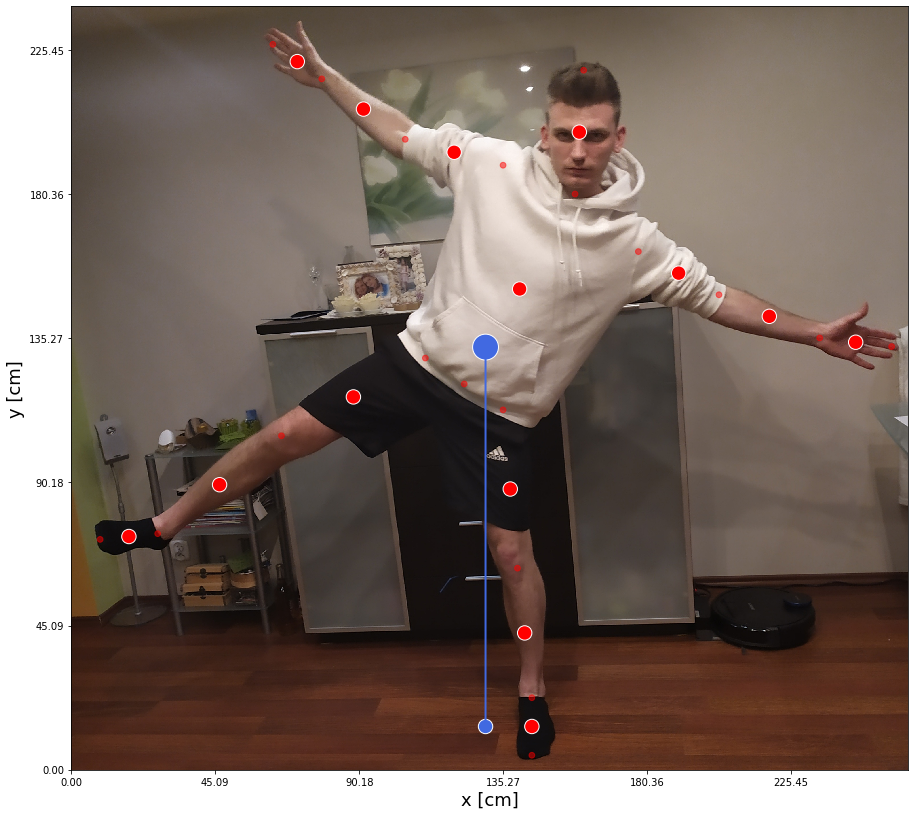

In [7]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(img, origin='lower')

for x, y in points_anchor:
    circ = Circle((x, y), 10, color='red', alpha=.5)
    ax.add_patch(circ)
    
for x, y in points_middle:
    circ = Circle((x, y), 25, color='red', ec='white')
    ax.add_patch(circ)
    
circ = Circle(center_mass, 45, color='royalblue', ec='white')    
ax.add_patch(circ)

circ = Circle(floor_anchor, 25, color='royalblue', ec='white')    
ax.add_patch(circ)

conn = ConnectionPatch(center_mass, floor_anchor, "data", color="royalblue", 
                       linewidth=2, mutation_scale=200)
ax.add_patch(conn)

formatter = FuncFormatter(lambda x_val, tick_pos: f'{PX_TO_CM * float(x_val):.2f}')

ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

ax.set_xlabel('x [cm]', size=18)
ax.set_ylabel('y [cm]', size=18)

plt.show()

# Save data to csv
df.to_csv('measures_centre_mass.csv')
df_len.to_csv('measures_conversion_rate.csv')